# Cook County House Pricing Prediction
## Part I. Data Cleaning and Exploration

In [3]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

### The Data

The data set consists of 500,000+ records from Cook County, Illinois. The data set has 61 features in total; the 62nd is sales price, will be the targe. The data are split into training and test sets with 204,792 and 68,264 observations, respectively.

In [5]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()
    
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

Double checking the dimensions of the dataset:

In [14]:
training_data.shape
assert 'Sale Price' in training_data.columns.values

Checking out all the columns in our training data:

In [15]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [70]:
# Looking at one description of a house
training_data["Description"].iloc[0]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

Some insights from first glance:
- Each row represents a single instance of a property sold, including multiple properties of it such as dimensions, location, and age.
- The reason for this data collection was to analyze the housing situation in Cook County. These data may be helpful for local authorities to assess how resources are allocated and how to better aid those in need of a housing plan.

Taking a look at the distribution of prices in the `Sale Price` column.

In [26]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)
    
    # seaborn distribution
    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
        color = "white"
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

Eliminate outliers, applying log-transformation and adding it as a new column:

In [27]:
training_data = training_data[training_data["Sale Price"] >= 500]
training_data["Log Sale Price"] = np.log(training_data["Sale Price"])

Visualizing `Log Sale Price`:

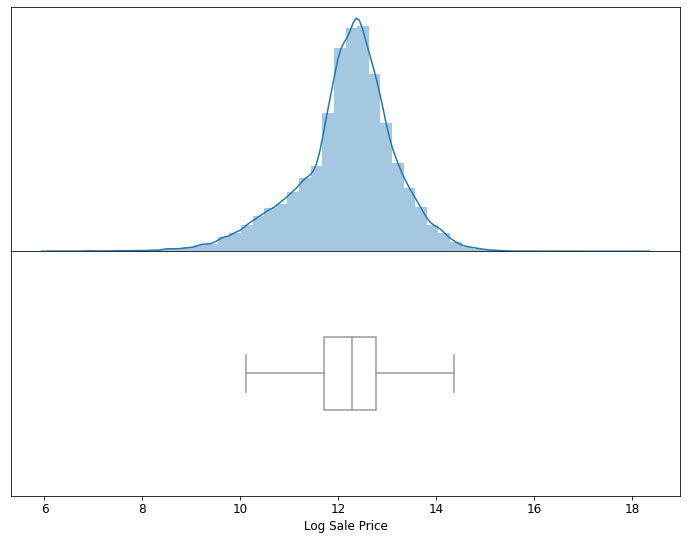

In [28]:
plot_distribution(training_data, label='Log Sale Price');

Explore correlations between variables to gain some insights:
1. Log Sale Price vs. Log Building Square Feet

In [29]:
# Creating new column for log-transformed building area
training_data["Log Building Square Feet"] = np.log(training_data["Building Square Feet"])

Lets visualize the correlation between the two variables with a jointplot:

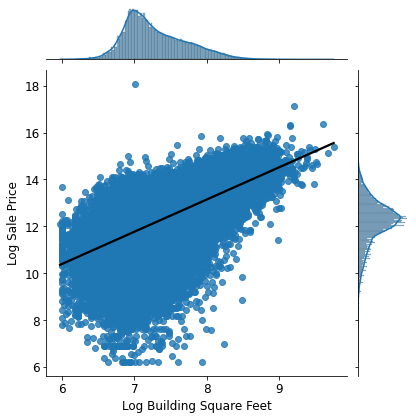

In [32]:
sns.jointplot(x='Log Building Square Feet', y='Log Sale Price', data=training_data, 
              kind="reg", joint_kws={'line_kws':{'color':'black'}})
plt.show()

It appears that there is a correlation between `Log Sale Price` and `Log Building Square Feet`. `Log Building Square Feet` would make a good candidate as one of the features for our model because of this possitive correlation.

### Useful Functions
Implementing some functions that will be useful in constructing features in the future. 
1. `remove_outliers` removes outliers from a column in the dataset with specified upper and lower bounds.
2. `add_total_bedrooms` extracts number of bedrooms from the `Descriptions` column.

In [58]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
    """  
    data = data[data[variable] <= upper]
    data = data[data[variable] >= lower]
    return data

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = training_data.Description.str.extract(r'rooms, (\d\d?)')
    with_rooms['Bedrooms'] = with_rooms['Bedrooms'].astype('int')
    return with_rooms


In [59]:
training_data = add_total_bedrooms(training_data)

Let's visualize the bedrooms data:

Text(0.5, 1.0, 'Distrbution of Log Sale Price for Different Number of Bedrooms')

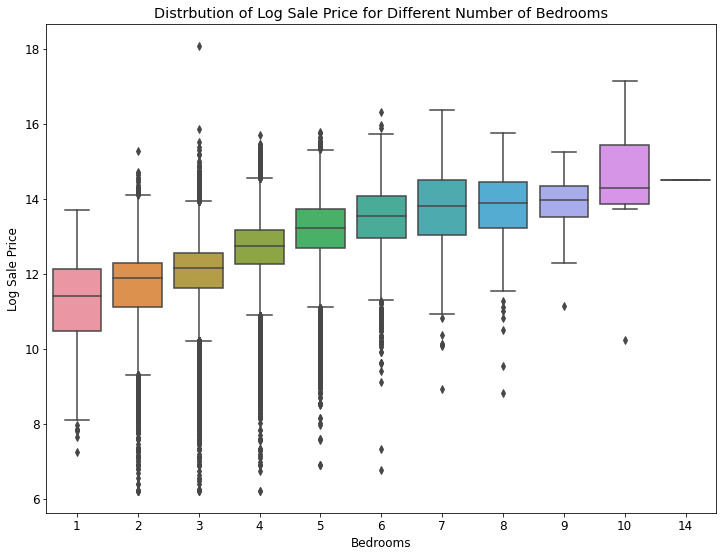

In [63]:
copy_training = training_data.copy()
copy_training = copy_training.sort_values(by = "Bedrooms")
sns.boxplot(
        x='Bedrooms',
        y='Log Sale Price',
        data=copy_training,
    )
plt.title("Distrbution of Log Sale Price for Different Number of Bedrooms")

### Neighborhood Code
The `Neighborhood` column contains information about different neighborhoods in the dataset. Let's check how many unique neighborhoods there are:

In [65]:
num_neighborhoods = len(training_data["Neighborhood Code"].unique())
print(f'There are {num_neighborhoods} unique neighborhoods in our dataset.')

There are 193 unique neighborhoods in our dataset.


Since there are so many different neighborhoods, it is too much to examine every single one. In order to avoid overplotting, only the top 20 neighborhoods will be included in the visualization.

In [66]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [68]:
# Top 20 neighborhood dataframe
top_20 = training_data["Neighborhood Code"].value_counts().head(20).index.tolist()
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20)]

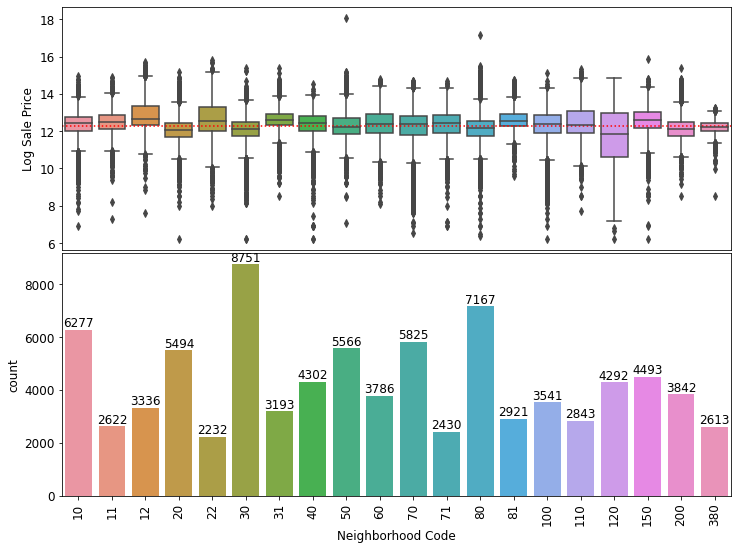

In [69]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

Looking at the plot above, the distributions seem to vary around the same median for all top 20 neighborhoods. The `sale price` and the neighborhood doesn't seem to be directly correlated.

This problem might be due to the fact that the data does include the remaining 173 neighborhoods. To solve this problem, manually create bins to classify neighborhoods as `expensive`.

In [73]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby("Neighborhood Code")["Log Sale Price"].agg(metric).sort_values(ascending=False).head(n)
    return [int(code) for code in neighborhoods.index.tolist()]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

Let's use the above information to write a function `add_expensive_neighborhood` that adds a column `in_expensive_neighborhood` which indicates if the house is part of `expensive_neighborhoods`.

In [74]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data["Neighborhood Code"].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)
sum(training_data.loc[:, 'in_expensive_neighborhood'])

1290

### Roof Material
Looking at the `Roof Material` column in the dataset, let's replace each numerical value in `Roof Material` with their corresponding roof material following the below mapping.
Central Heating (Nominal): 

       1    Shingle/Asphalt
       2    Tar&Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other

In [76]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace({'Roof Material': {1.0: "Shingle/Asphalt", 2.0: "Tar&Gravel", 3.0:"Slate", 4.0:"Shake", 5.0:"Tile", 6.0:"Other"}})
    return data
    
training_data = substitute_roof_material(training_data)
training_data.head(1)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.",3780.0,12.560244,6.904751,3,0


Since `Roof Material` is a categorical variable, we must one-hot-encode the data to be used in our linear model. 

The following function `ohe_roof_material` returns a dataframe with the new column one-hot-encoded on the roof material of the household. These new columns has the form `x0_MATERIAL`.

In [77]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_array = enc.fit_transform(data[['Roof Material']]).toarray()
    feature_names = enc.get_feature_names()
    data[feature_names] = enc_array
    return data

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


## Part II. Model Training and Prediction with Linear Regression

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution.

In [92]:
def train_test_split(data):
    '''
    Split data into training and testing sets.
    '''
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(data_len * 0.8)].tolist()
    test_indices = shuffled_indices[int(data_len * 0.8):].tolist()
    return data.iloc[train_indices], data.iloc[test_indices]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

In [86]:
interesting_features = training_data[["Property Class", "Neighborhood Code", "Land Square Feet", "Town Code", 
              "Apartments", "Log Sale Price", "Log Building Square Feet", "Bedrooms", 
              "in_expensive_neighborhood", "x0_Other", "x0_Shake", "x0_Shingle/Asphalt", 
              "x0_Slate", "x0_Tar&Gravel", "x0_Tile"]]

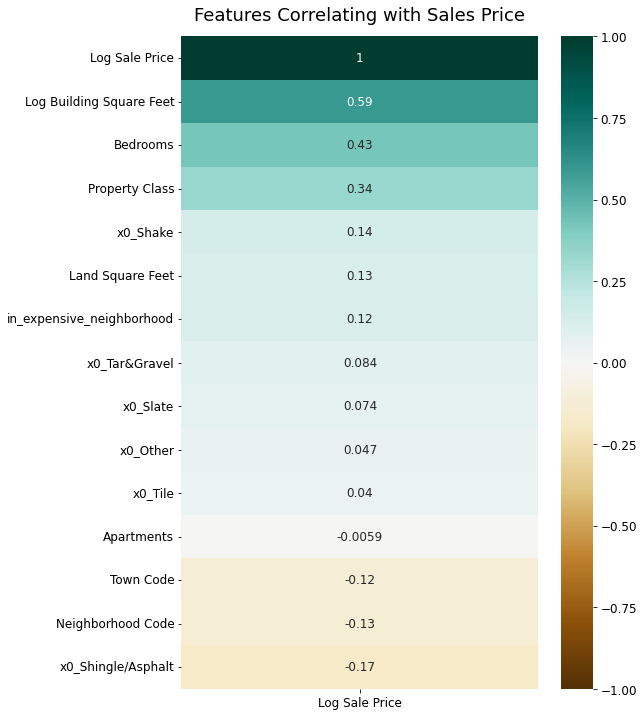

In [89]:
# Increase the size of the heatmap.
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(interesting_features.corr()[['Log Sale Price']].sort_values(by='Log Sale Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

Writing Functions that will be fed into data pipeline for model training.

In [90]:
def substitute_data(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace({'Roof Material': {1.0: "Shingle/Asphalt", 2.0: "Tar&Gravel", 3.0:"Slate", 4.0:"Shake", 5.0:"Tile", 6.0:"Other"}})
    data = data.replace({'Wall Material': {1.0: "Wood", 2.0: "Masonry", 3.0: "Wood&Masonry", 4.0:"Stucco"}})
    return data

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form x0_MATERIAL.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_array = enc.fit_transform(data[['Roof Material']]).toarray()
    feature_names = enc.get_feature_names()
    data[feature_names] = enc_array
    return data

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = training_data.Description.str.extract('rooms, (\d\d?)')
    return with_rooms

def add_total_rooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Rooms"] = training_data.Description.str.extract('(\d\d?) rooms, ')
    return with_rooms

def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bathrooms"] = training_data.Description.str.extract(', and (\d\d?)')
    return with_rooms

def add_stories(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Stories"] = training_data.Description.str.extract('([a-z]+)-story')
    with_rooms = with_rooms.replace({'Stories': {"one": 1.0, "two": 2.0, "three": 3.0, "four": 4.0}})
    with_rooms["Stories"].fillna(0)
    return with_rooms

#####################
### DATA PIPELINE ###
#####################
def process_data_fm(data):
    # Return predictors and response variables separately
    log_transform(data, "Building Square Feet")
    log_transform(data, "Sale Price")
    log_transform(data, "Estimate (Land)")
    log_transform(data, "Estimate (Building)")
    substitute_data(data)
    data = add_total_bedrooms(data)
    data = add_total_bathrooms(data)
    data = add_total_rooms(data)
    data = add_stories(data)
    data = remove_outliers(data, "Sale Price", lower=499, upper=500000)
    data = remove_outliers(data, "Log Estimate (Land)", lower=2)
    data = remove_outliers(data, "Log Estimate (Building)", lower=8)
    data = data[["Bedrooms", "Log Building Square Feet", "Log Sale Price", "Log Estimate (Land)", "Log Estimate (Building)", "Pure Market Filter"]]
    X = data
    X = data.drop(['Log Sale Price'], axis = 1)
    y = data.loc[:, 'Log Sale Price']
    return X, y

In [95]:
from sklearn import linear_model as lm

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted) ** 2))

training_data = pd.read_csv('cook_county_train.csv')
X_train, y_train = process_data_fm(training_data)
model = lm.LinearRegression(fit_intercept = True)
model.fit(X_train, y_train)
y_predicted = model.predict(X_train)
loss = rmse(y_predicted, y_train)
loss_delog = rmse(np.exp(y_predicted), np.exp(y_train))
print('RMSE loss logged is {}'.format(loss))
print('RMSE loss de-logged is: {}'.format(loss_delog))

RMSE loss logged is 0.5301141338624226
RMSE loss de-logged is: 111973.23025276093


## Conclusions
The RMSE error evaluates the accuracy of the prediction model, whether the county office is evaluating the value of the houses fairly. If for a homeowner, the root mean squared error is a high magnitude, that means their house is being overvalued or undervalued according to the prediction model. If their house is overvalued, they must pay higher taxes than they should be. On the other hand, if their house is undervalued, they must pay lower taxes than they would be. <br>
<br>
I would define fairness in property assessments and taxes as fairly calculating the value of homes based on non-racial/gender information. The value of the houses should mainly be based on tangible measurements and physical characteristics. The assessment should also take into account the neighborhood and the income of the homeowners. Taxes should reflect the financial ability of the homeowner and give a managable amount for the homeowner. 